## Least squares TDOA or TOA is not a convex problem

If we work with a time-difference-of-arrival system where a single transmission is simultaneously received by multiple receivers, we could try to express it as a least square minimization problem

$$ \begin{align}
min & \: \epsilon^T W \epsilon \\
s.t. & \: t_i = \tau + \| p - \pi_i\| + \epsilon_i
\end{align}$$

Here

- $i$ represents the reception on a $i^\text{th}$ receiver
- $t_i$ is the time of the reception
- $\tau$ is the time when it was transmitted
- $p$ is the position of the transmitter
- $\pi_i$ is the position of the $i^\text{th}$ receiver.

This problem formulation is not convex. Thus it cannot be solved by standard quadratic optimization, cone programming or semidefinite methods.

One possibility is to use gradient desent with the appropriate starting points.

Here is an example scenario which shows why the TDOA formulation cannot be convex

Note that $t_i - \tau = \frac{\text{actual distance}}{c}$
Thus the constrains become $\frac{\text{actual dist}_i}{c} = \frac{\text{estimated dist}_i}{c} + \epsilon_i$

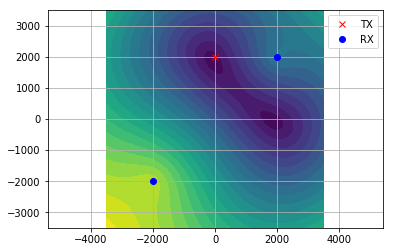

In [139]:
import numpy as np
import matplotlib.pyplot as plt

def pos(x,y):
    """Quick shortcut to convert X,Y position to numpy array"""
    return np.array([x,y])

def pos3D(x,y,z):
    """Quick shortcut to convert X,Y,Z position to numpy array"""
    return np.array([x,y,z])

class Device:
    """This is a general class for a radio device"""
    def __init__(self, position):
        """Expects a numpy array with position coordinates in meters"""
        self.pos = position
    
    def distanceTo(self, otherDevice):
        """When supplied the identity of another device, outputs the distance in meters"""
        return np.linalg.norm(self.pos - otherDevice.pos, ord = 2)
    
    def distances(self, positions):
        """When provided an array of positions (each position is a row), computes a vector of distances to each"""
        return np.linalg.norm(positions - self.pos, ord = 2, axis = 1)
    
    def plot(self, *args, **kwargs):
        plt.plot(self.pos[0], self.pos[1], *args, **kwargs)
        
def combinedPositionMatrix(deviceList):
    """Given a list of Devices, give a numpy array with just their positions in a single matrix.
    Each device position is a row. Order of the devices is maintained"""
    n = len(deviceList)
    positions = np.empty([n, 2]) # Assuming 2D space
    for index, dev in enumerate(deviceList):
        positions[index] = dev.pos
    return positions


    
# all positions are in m
# TODO: find a situation where we have a local minima
tx = Device(pos(0,2000))
rx1 = Device(pos(-2000., -2000))
rx2 = Device(pos(2000, 2000))
rx3 = Device(pos(-2000, 2000))
rx4 = Device(pos(2000, -2000))
rx5 = Device(pos(0, 3000))
rx6 = Device(pos(0, -3000))

# rxDevices = [rx1, rx2, rx3, rx4, rx5, rx6]
rxDevices = [rx1, rx2]

rxPositions = combinedPositionMatrix(rxDevices)
x = np.linspace(-3500, 3500, 400)
y = np.linspace(-3500, 3500, 400)
x,y = np.meshgrid(x, y)

# a position matrix contains many positions in a single matrix. Each row corresponds to a different position.
# This is useful when we want to perform quick computations with distances

oldShape = x.shape
positions = np.swapaxes(np.stack((np.reshape(x, -1), np.reshape(y, -1))), 0, 1)

noiseStdev = 300.0 # standard deviation of noise

def getError(txDevice, rxDevice, positions):
    measuredDistance = rxDevice.distanceTo(txDevice) + np.random.normal(scale = noiseStdev)
    estimatedDistance = rxDevice.distances(positions)
    error = measuredDistance - estimatedDistance
    return error

def getTotalError(txDevice, rxDevices, positions):
    nRxDevices = len(rxDevices)
    nPos, nDim = positions.shape
    error = np.empty([nRxDevices, nPos])
    for devIndex, dev in enumerate(rxDevices):
        error[devIndex] = getError(txDevice, dev, positions)
    return np.linalg.norm(error, ord = 2, axis = 0)

errorVector = getTotalError(tx, rxDevices, positions)
errorGrid = np.reshape(errorVector, oldShape)

# plot and show
plt.figure()
plt.axis('equal')
plt.xlim([-3500, 3500])
plt.ylim([-3500, 3500])
tx.plot('rx', label = 'TX')
rx1.plot('bo', label = 'RX')
rx2.plot('bo')
# rx3.plot('bo')
# rx4.plot('bo')
# rx5.plot('bo')
# rx6.plot('bo')
plt.contourf(x, y, errorGrid, 20)
plt.legend()
plt.grid()
plt.show()